In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeClassifier,Ridge
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from catboost import CatBoostClassifier,CatBoostRegressor
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier

In [410]:
X = pd.read_csv('data/X_train.csv',index_col='ROW_ID')
X_test_final = pd.read_csv('data/X_test.csv',index_col='ROW_ID')
y = pd.read_csv('data/y_train.csv',index_col='ROW_ID')
y_bin = (y > 0).astype(int) #binariser l outcome pour faire de la classification et pas regression
sample_submission = pd.read_csv('data/sample_submission.csv',index_col='ROW_ID')

In [411]:

RET_features = [f'RET_{i}' for i in range(1, 20)]
SIGNED_VOLUME_features = [f'SIGNED_VOLUME_{i}' for i in range(1, 20)]
TURNOVER_features = ['AVG_DAILY_TURNOVER']

for i in range(2, 21):
    X[f'AVERAGE_PERF_{i}'] = X[RET_features[:i]].mean(1)
    X[f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X.groupby('TS')[f'AVERAGE_PERF_{i}'].transform('mean')
    X_test_final[f'AVERAGE_PERF_{i}'] = X_test_final[RET_features[:i]].mean(1)
    X_test_final[f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_test_final.groupby('TS')[f'AVERAGE_PERF_{i}'].transform('mean')


In [412]:
X["RET_VOLATILITY_20"] = X[RET_features].std(axis=1)
X_test_final["RET_VOLATILITY_20"] = X_test_final[RET_features].std(axis=1)

X["RET_MOMENTUM"] = X["RET_1"] - X[RET_features].mean(axis=1)
X_test_final["RET_MOMENTUM"] = X_test_final["RET_1"] - X_test_final[RET_features].mean(axis=1)

# Ratio perf/vol (Sharpe-like)
X["RET_SHARPE"] = X["RET_MOMENTUM"] / (X["RET_VOLATILITY_20"] + 1e-6)
X_test_final["RET_SHARPE"] = X_test_final["RET_MOMENTUM"] / (X_test_final["RET_VOLATILITY_20"] + 1e-6)

# Liquidity volatility
X["SIGNED_VOLUME_VOL"] = X[SIGNED_VOLUME_features].std(axis=1)
X_test_final["SIGNED_VOLUME_VOL"] = X_test_final[SIGNED_VOLUME_features].std(axis=1)

X["TS_num"] = X["TS"].str.extract("(\d+)").astype(int)
X_test_final["TS_num"] = X_test_final["TS"].str.extract("(\d+)").astype(int)

X["RET_TREND_5"] = X["RET_20"] - X["RET_15"]
X["VOL_TREND_5"] = X["SIGNED_VOLUME_20"] - X["SIGNED_VOLUME_15"]
X_test_final["RET_TREND_5"] = X_test_final["RET_20"] - X_test_final["RET_15"]
X_test_final["VOL_TREND_5"] = X_test_final["SIGNED_VOLUME_20"] - X_test_final["SIGNED_VOLUME_15"]

# Décalage du dernier retour
X["RET_LAG1"] = X["RET_1"]
X["RET_DIFF1"] = X["RET_1"] - X["RET_2"]
X_test_final["RET_LAG1"] = X_test_final["RET_1"]
X_test_final["RET_DIFF1"] = X_test_final["RET_1"] - X_test_final["RET_2"]
# Skewness et kurtosis sur les 20 derniers jours
X["RET_SKEW_20"] = X[RET_features].skew(axis=1)
X["RET_KURT_20"] = X[RET_features].kurt(axis=1)
X_test_final["RET_SKEW_20"] = X_test_final[RET_features].skew(axis=1)
X_test_final["RET_KURT_20"] = X_test_final[RET_features].kurt(axis=1)
# Ratio volume/performance (liquidité relative)
X["VOL_PERF_RATIO"] = X[SIGNED_VOLUME_features].mean(axis=1) / (X[RET_features].std(axis=1) + 1e-6)

# Moyenne pondérée des performances récentes (momentum lissé)
weights = np.linspace(1, 2, 19)
X["RET_WEIGHTED_MOMENTUM"] = (X[RET_features].values * weights).sum(axis=1) / weights.sum()

X_test_final["VOL_PERF_RATIO"] = X_test_final[SIGNED_VOLUME_features].mean(axis=1) / (X_test_final[RET_features].std(axis=1) + 1e-6)

# Moyenne pondérée des performances récentes (momentum lissé)
weights = np.linspace(1, 2, 19)
X_test_final["RET_WEIGHTED_MOMENTUM"] = (X_test_final[RET_features].values * weights).sum(axis=1) / weights.sum()




<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_32150/2253576490.py:15: SyntaxWarning: invalid escape sequence '\d'
  X["TS_num"] = X["TS"].str.extract("(\d+)").astype(int)
/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_32150/2253576490.py:16: SyntaxWarning: invalid escape sequence '\d'
  X_test_final["TS_num"] = X_test_final["TS"].str.extract("(\d+)").astype(int)


In [413]:
from sklearn.linear_model import LinearRegression
lags = np.arange(1, 21)
model = LinearRegression()

trend = []
for i in range(len(X)):
    y1 = X.loc[i, [f'RET_{j}' for j in range(1, 21)]].values
    model.fit(lags.reshape(-1,1), y1)
    trend.append(model.coef_[0])
X["RET_TREND_SLOPE_20"] = trend

X["RET_PAST_SKEW"] = X[[f'RET_{i}' for i in range(1, 6)]].mean(axis=1) - \
                     X[[f'RET_{i}' for i in range(6, 21)]].mean(axis=1)
X["RET_SHORT_LONG_RATIO"] = (
    X[[f'RET_{i}' for i in range(1, 5)]].mean(axis=1) /
    (X[[f'RET_{i}' for i in range(5, 21)]].mean(axis=1) + 1e-6)
)
rets = X[[f'RET_{i}' for i in range(1, 21)]]
X["RET_ASYM_VOL"] = rets.clip(lower=0).std(axis=1) - rets.clip(upper=0).std(axis=1)

X["rank_perf_20"] = X.groupby("TS")["AVERAGE_PERF_20"].rank(pct=True)


In [414]:
'''''
features = [
 'RET_SHARPE', 'RET_15', 'RET_TREND_5', 'AVERAGE_PERF_20',
 'ALLOCATIONS_AVERAGE_PERF_5', 'RET_1', 'RET_6', 'SIGNED_VOLUME_3',
 'SIGNED_VOLUME_19', 'ALLOCATIONS_AVERAGE_PERF_10', 'ALLOCATIONS_AVERAGE_PERF_3',
 'ALLOCATIONS_AVERAGE_PERF_15', 'RET_MOMENTUM', 'alloc_enc'
]

# Target encoding
enc = TargetEncoder()
X["alloc_enc"] = enc.fit_transform(X["ALLOCATION"], y_bin)
X_test_final["alloc_enc"] = enc.transform(X_test_final["ALLOCATION"])
X=X[features]
X_test_final=X_test_final[features]
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))
X_test_final_scaled = scaler.transform(X_test_final.fillna(0))

# Entraînement Ridge sur tout le dataset
new_ridge = RidgeClassifier(alpha=1e-2, fit_intercept=False)
new_ridge.fit(X_scaled, y_bin.values.ravel())

# Prédiction
preds_ridge = pd.DataFrame(
    new_ridge.predict(X_test_final_scaled),
    index=sample_submission.index,
    columns=['target']
)
(preds_ridge>0).astype(int).to_csv('preds_ridge_boost.csv')
'''''

'\'\'\nfeatures = [\n \'RET_SHARPE\', \'RET_15\', \'RET_TREND_5\', \'AVERAGE_PERF_20\',\n \'ALLOCATIONS_AVERAGE_PERF_5\', \'RET_1\', \'RET_6\', \'SIGNED_VOLUME_3\',\n \'SIGNED_VOLUME_19\', \'ALLOCATIONS_AVERAGE_PERF_10\', \'ALLOCATIONS_AVERAGE_PERF_3\',\n \'ALLOCATIONS_AVERAGE_PERF_15\', \'RET_MOMENTUM\', \'alloc_enc\'\n]\n\n# Target encoding\nenc = TargetEncoder()\nX["alloc_enc"] = enc.fit_transform(X["ALLOCATION"], y_bin)\nX_test_final["alloc_enc"] = enc.transform(X_test_final["ALLOCATION"])\nX=X[features]\nX_test_final=X_test_final[features]\n# Scaling\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X.fillna(0))\nX_test_final_scaled = scaler.transform(X_test_final.fillna(0))\n\n# Entraînement Ridge sur tout le dataset\nnew_ridge = RidgeClassifier(alpha=1e-2, fit_intercept=False)\nnew_ridge.fit(X_scaled, y_bin.values.ravel())\n\n# Prédiction\npreds_ridge = pd.DataFrame(\n    new_ridge.predict(X_test_final_scaled),\n    index=sample_submission.index,\n    columns=[\'target

In [ ]:
features = (
    RET_features
    + SIGNED_VOLUME_features
    + TURNOVER_features
    + [f'AVERAGE_PERF_{i}' for i in range(2, 21)]
    + [f'ALLOCATIONS_AVERAGE_PERF_{i}' for i in range(2, 21)]
    + ["RET_VOLATILITY_20", "RET_MOMENTUM", "RET_SHARPE", "SIGNED_VOLUME_VOL","VOL_TREND_5","RET_TREND_5"]
    + ["alloc_enc"]
    +["rank_perf_20"]
    +["VOL_PERF_RATIO","RET_KURT_20","RET_SKEW_20","RET_DIFF1","RET_LAG1"]
    +[ "ALLOC_TREND_SLOPE","ALLOC_SHORT_LONG_RATIO","ALLOC_AUTOCORR","ALLOC_SPECTRAL_ENERGY","ALLOC_VOLATILITY","ALLOC_SKEW"]
    +["RET_TREND_SLOPE_20","RET_PAST_SKEW","RET_SHORT_LONG_RATIO","RET_ASYM_VOL"]
)

In [416]:
agg_cols = [c for c in X.columns if c.startswith("ALLOCATIONS_AVERAGE_PERF_")]
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(X[agg_cols].fillna(0))
X_pcs = pca.transform(X[agg_cols].fillna(0))
X_test_pcs = pca.transform(X_test_final[agg_cols].fillna(0))
for i in range(X_pcs.shape[1]):
    X[f"allocpc_{i+1}"] = X_pcs[:, i]
    features.append(f"allocpc_{i+1}")



/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/olivierf/stanford/QRT-Asset-Allocation-Performan

In [417]:
alloc_col = "ALLOCATION"
ret_cols = [f'RET_{i}' for i in range(1, 21)]
def compute_time_features_for_allocation(df_alloc):
    mean_rets = df_alloc[ret_cols].mean()

    x = np.arange(1, 21).reshape(-1, 1)
    model = LinearRegression().fit(x, mean_rets.values)
    slope = model.coef_[0]

    short_mean = mean_rets[:5].mean()
    long_mean = mean_rets[5:].mean()
    short_long_ratio = short_mean / (long_mean + 1e-6)

    autocorr = np.corrcoef(mean_rets[:-1], mean_rets[1:])[0, 1]

    fft_vals = np.fft.rfft(mean_rets - mean_rets.mean())
    spectral_energy = np.sum(np.abs(fft_vals)**2)

    # 5. Volatilité et asymétrie
    volatility = mean_rets.std()
    skew = ((mean_rets - mean_rets.mean())**3).mean() / (volatility**3 + 1e-6)

    return pd.Series({
        "ALLOC_TREND_SLOPE": slope,
        "ALLOC_SHORT_LONG_RATIO": short_long_ratio,
        "ALLOC_AUTOCORR": autocorr,
        "ALLOC_SPECTRAL_ENERGY": spectral_energy,
        "ALLOC_VOLATILITY": volatility,
        "ALLOC_SKEW": skew
    })

In [418]:
unique_dates = np.sort(X['TS'].unique())
n = len(unique_dates)
train_dates = unique_dates[: int(0.8 * n)]   # 80% train
test_dates = unique_dates[int(0.8 * n):]     # 20% test

train_idx = X['TS'].isin(train_dates)
test_idx = X['TS'].isin(test_dates)

X_train, y_train_bin, y_train_cont = X.loc[train_idx, :], y_bin.loc[train_idx], y.loc[train_idx]
X_test, y_test_bin, y_test_cont = X.loc[test_idx, :], y_bin.loc[test_idx], y.loc[test_idx]


In [419]:
enc = TargetEncoder()
X_train["alloc_enc"] = enc.fit_transform(X_train["ALLOCATION"], y_train_bin)
X_test["alloc_enc"] = enc.transform(X_test["ALLOCATION"], y_test_bin)


/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_32150/1431446780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["alloc_enc"] = enc.fit_transform(X_train["ALLOCATION"], y_train_bin)
/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_32150/1431446780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["alloc_enc"] = enc.transform(X_test["ALLOCATION"], y_test_bin)


In [420]:
alloc_features = X_train.groupby(alloc_col).apply(compute_time_features_for_allocation).reset_index()
X_train = X_train.merge(alloc_features, on=alloc_col, how="left")

alloc_features_test = X_test.groupby(alloc_col).apply(compute_time_features_for_allocation).reset_index()
X_test = X_test.merge(alloc_features_test, on=alloc_col, how="left")


/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_32150/139727217.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  alloc_features = X_train.groupby(alloc_col).apply(compute_time_features_for_allocation).reset_index()
/var/folders/1w/qdnlgvv57jsctw3wf6pt0wlr0000gn/T/ipykernel_32150/139727217.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  alloc_features_test = X_test.groupby(alloc_col).apply(compute_ti

In [421]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features].fillna(0))
X_test_scaled = scaler.transform(X_test[features].fillna(0))

In [428]:
results_classif = {}

name, model="RidgeClassifier",RidgeClassifier(alpha=1e-2, fit_intercept=False)
model.fit(X_train_scaled, y_train_bin)
y_pred = model.predict(X_test_scaled)


# Évaluation
acc = accuracy_score(y_test_bin, y_pred)
results_classif[name] = acc
print(f"✅ Test Accuracy ({name}): {acc:.4f}")

# Importance des features
print("\n🔍 Top 10 feature importances:")

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_.ravel())  # abs pour Ridge

importance_df = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)
top_half = importance_df.iloc[:importance_df.shape[0] // 2]["feature"].tolist()
best_ridge = top_half



✅ Test Accuracy (RidgeClassifier): 0.5256

🔍 Top 10 feature importances:


/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-

In [429]:
scaler = StandardScaler()
features=best_ridge
X_train_scaled = scaler.fit_transform(X_train[features].fillna(0))
X_test_scaled = scaler.transform(X_test[features].fillna(0))

In [430]:
models_classif = {
    "RidgeClassifier": RidgeClassifier(alpha=1e-2, fit_intercept=False),
    '''
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
    
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss',
    ),'''
    
    "CatBoost": CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        verbose=0
    )
}

In [431]:
models_classif = {
    "RidgeClassifier": RidgeClassifier(alpha=1e-2, fit_intercept=False),
    "CatBoost": CatBoostClassifier(
        iterations=500,
        depth=6,
        learning_rate=0.05,
        random_seed=42,
        verbose=0
    )
}


Training RidgeClassifier (classification)...
✅ Test Accuracy (RidgeClassifier): 0.5293

🔍 Top 10 feature importances:
                        feature  importance
0                     alloc_enc    0.051395
36                 RET_MOMENTUM    0.038521
2    ALLOCATIONS_AVERAGE_PERF_9    0.036970
1   ALLOCATIONS_AVERAGE_PERF_10    0.036792
3   ALLOCATIONS_AVERAGE_PERF_14    0.035472
5   ALLOCATIONS_AVERAGE_PERF_16    0.035451
4   ALLOCATIONS_AVERAGE_PERF_13    0.031805
38                     RET_LAG1    0.031592
37                        RET_1    0.031592
6   ALLOCATIONS_AVERAGE_PERF_17    0.028530
8                    RET_SHARPE    0.021716
7   ALLOCATIONS_AVERAGE_PERF_11    0.020738
10                       RET_15    0.019822
9    ALLOCATIONS_AVERAGE_PERF_6    0.015833
18                  RET_TREND_5    0.014912
21  ALLOCATIONS_AVERAGE_PERF_15    0.014497
12  ALLOCATIONS_AVERAGE_PERF_18    0.014124
14  ALLOCATIONS_AVERAGE_PERF_20    0.012575
15  ALLOCATIONS_AVERAGE_PERF_19    0.012575
1

/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-

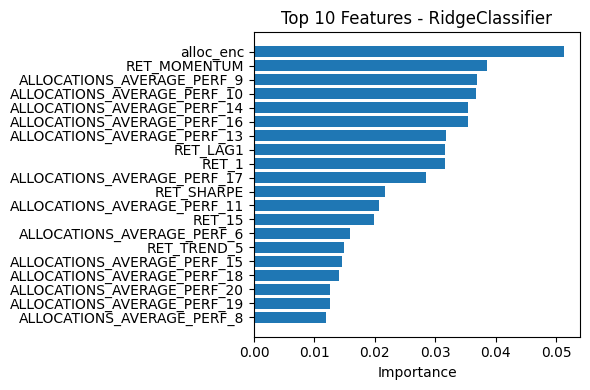


Training CatBoost (classification)...
✅ Test Accuracy (CatBoost): 0.5243

🔍 Top 10 feature importances:
                        feature  importance
9    ALLOCATIONS_AVERAGE_PERF_6    5.006798
32   ALLOCATIONS_AVERAGE_PERF_4    4.772342
34                    allocpc_2    4.565580
1   ALLOCATIONS_AVERAGE_PERF_10    4.424352
0                     alloc_enc    4.280696
13   ALLOCATIONS_AVERAGE_PERF_8    4.106262
2    ALLOCATIONS_AVERAGE_PERF_9    4.058036
7   ALLOCATIONS_AVERAGE_PERF_11    3.816058
5   ALLOCATIONS_AVERAGE_PERF_16    3.598966
11   ALLOCATIONS_AVERAGE_PERF_7    3.525268
6   ALLOCATIONS_AVERAGE_PERF_17    3.059141
26  ALLOCATIONS_AVERAGE_PERF_12    2.986560
4   ALLOCATIONS_AVERAGE_PERF_13    2.977655
21  ALLOCATIONS_AVERAGE_PERF_15    2.792549
3   ALLOCATIONS_AVERAGE_PERF_14    2.784669
17                       RET_11    2.694163
25                        RET_9    2.522914
12  ALLOCATIONS_AVERAGE_PERF_18    2.515560
14  ALLOCATIONS_AVERAGE_PERF_20    2.448684
33             

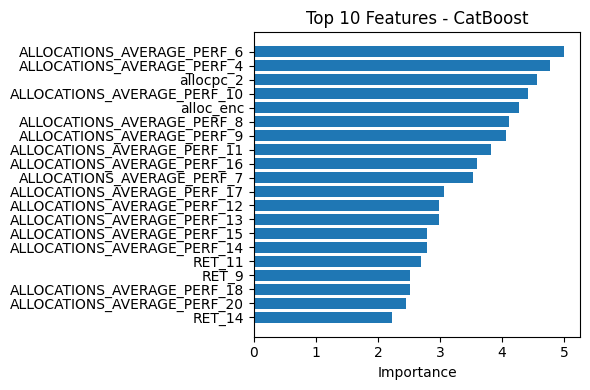

In [432]:
results_classif = {}

for name, model in models_classif.items():
    print(f"\n{'='*30}\nTraining {name} (classification)...\n{'='*30}")
    
    # Entraînement
    if "Ridge" in name:
        model.fit(X_train_scaled, y_train_bin)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train[features].fillna(0), y_train_bin.values.ravel())
        y_pred = model.predict(X_test[features].fillna(0))
    
    # Évaluation
    acc = accuracy_score(y_test_bin, y_pred)
    results_classif[name] = acc
    print(f"✅ Test Accuracy ({name}): {acc:.4f}")
    
    # Importance des features
    print("\n🔍 Top 10 feature importances:")
    try:
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_.ravel())  # abs pour Ridge
        else:
            raise AttributeError("No feature importance attribute found.")
        
        importance_df = pd.DataFrame({
            "feature": features,
            "importance": importances
        }).sort_values("importance", ascending=False)
        top_half = importance_df.iloc[:importance_df.shape[0] // 2]["feature"].tolist()

        if "Ridge" in name:
            best_ridge = top_half
        elif "Random" in name:
            best_rf = top_half
        print(importance_df.head(20))
        
        # Plot
        plt.figure(figsize=(6, 4))
        plt.barh(importance_df["feature"].head(20)[::-1],
                 importance_df["importance"].head(20)[::-1])
        plt.title(f"Top 10 Features - {name}")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"⚠️ Could not compute feature importances for {name}: {e}")



In [433]:
# Arrondir à 0.01
results_classif_rounded = {k: round(v, 3) for k, v in results_classif.items()}

print("\nClassification results (arrondi à 0.01):")
print(results_classif_rounded)



Classification results (arrondi à 0.01):
{'RidgeClassifier': 0.529, 'CatBoost': 0.524}
